In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from scipy import stats

# Load the data
df = pd.read_csv('data.csv')

# Display the first few rows of the dataframe
print(df.head())

# Group the data by condition
groups = df.groupby('Condition')

# Descriptive statistics for each group
print(groups.describe())

# Hypothesis 1: EMS and Visual + EMS groups have significantly fewer errors and faster reaction times
# Perform a t-test for ErrorCount and AvgReactionTime between groups
control = df[df['Condition'] == 'Control']
ems = df[df['Condition'] == 'EMS']
visual = df[df['Condition'] == 'Visual']
ems_visual = df[df['Condition'] == 'EMSVisual']

# H1: ErrorCount
t_stat, p_val = stats.ttest_ind(ems['ErrorCount'], control['ErrorCount'])
print(f'H1 ErrorCount: t-statistic = {t_stat}, p-value = {p_val}')

t_stat, p_val = stats.ttest_ind(ems_visual['ErrorCount'], visual['ErrorCount'])
print(f'H1 ErrorCount: t-statistic = {t_stat}, p-value = {p_val}')

# H1: AvgReactionTime
t_stat, p_val = stats.ttest_ind(ems['AvgReactionTime'], control['AvgReactionTime'])
print(f'H1 AvgReactionTime: t-statistic = {t_stat}, p-value = {p_val}')

t_stat, p_val = stats.ttest_ind(ems_visual['AvgReactionTime'], visual['AvgReactionTime'])
print(f'H1 AvgReactionTime: t-statistic = {t_stat}, p-value = {p_val}')

# Hypothesis 2 and 3 would be similar, but you would need to add the columns for NASA TLX-Scores and UEQ-Scores to your CSV file.

   SubjectID nickname  Condition  ErrorCount  CorrectCount  TotalTime  \
0          1    Kathy    Control           1            49   105.4166   
1          1    Kathy     Visual           1            49   110.4977   
2          1    Kathy        EMS           0            50   109.2863   
3          1    Kathy  EMSVisual           0            50   113.2684   
4          2   Julien     Visual           1            49   109.9137   

   AvgReactionTime  TimeInZoneHigh  TimeInZoneLow  
0         2.108334       18.178380       8.187508  
1         2.209951        8.285627      17.262210  
2         2.185727        7.504075       9.106119  
3         2.265368       19.976550      11.667920  
4         2.198277       16.727360      21.942710  
          SubjectID                                           ErrorCount       \
              count mean      std  min   25%  50%   75%   max      count mean   
Condition                                                                       
Contro

The results of the t-tests for Hypothesis 1(H1) indicate that there are no significant differences in ErrorCount or AvgReactionTime between the 'EMS' and 'Control' groups, or between the 'EMSVisual' and 'Visual' groups (all p-values > 0.05). 

Therefore, Hypothesis 1 is not supported by the data.

# Error Count

Test for normality and sphericity.


The results of the Shapiro-Wilk test indicate that the normality assumption is violated for all conditions except for the 'Visual' condition (where p > 0.05). This means that the data for 'Control', 'EMS', and 'EMSVisual' conditions are not normally distributed.

The Levene's test, however, indicates that the homogeneity of variance assumption is met (p > 0.05), meaning that the variances across the different conditions are equal.

In [6]:
# Import necessary libraries
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.anova import AnovaRM
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.stats.multitest import multipletests

# Load the data
df = pd.read_csv('data.csv')

# Check normality
for condition in df['Condition'].unique():
    print(f"Normality test for condition {condition}:")
    w, p = stats.shapiro(df[df['Condition'] == condition]['ErrorCount'])
    print(f"W = {w}, p = {p}")

# Check homogeneity of variance
w, p = stats.levene(
    df[df['Condition'] == 'Control']['ErrorCount'],
    df[df['Condition'] == 'EMS']['ErrorCount'],
    df[df['Condition'] == 'Visual']['ErrorCount'],
    df[df['Condition'] == 'EMSVisual']['ErrorCount']
)
print(f"\nLevene's test for homogeneity of variance: W = {w}, p = {p}")


Normality test for condition Control:
W = 0.7749409079551697, p = 0.007183539215475321
Normality test for condition Visual:
W = 0.8488086462020874, p = 0.05622288957238197
Normality test for condition EMS:
W = 0.8058674335479736, p = 0.017084049060940742
Normality test for condition EMSVisual:
W = 0.623032808303833, p = 0.00010420189937576652

Levene's test for homogeneity of variance: W = 0.22105263157894747, p = 0.8811395045200913


In [7]:
# Import necessary libraries
import scipy.stats as stats

# Perform Friedman test
chi2, p = stats.friedmanchisquare(
    df[df['Condition'] == 'Control']['ErrorCount'],
    df[df['Condition'] == 'EMS']['ErrorCount'],
    df[df['Condition'] == 'Visual']['ErrorCount'],
    df[df['Condition'] == 'EMSVisual']['ErrorCount']
)
print(f"Friedman test: chi2 = {chi2}, p = {p}")

Friedman test: chi2 = 5.619718309859128, p = 0.13165092339327872


The result of the Friedman test indicates that there are no significant differences in ErrorCount between the four conditions (p > 0.05). This suggests that the different conditions did not have a significant effect on the number of errors made by the participants.

Given these results, it seems that neither the 'EMS' nor the 'EMSVisual' conditions led to significantly fewer errors or faster reaction times compared to the 'Control' or 'Visual' conditions, respectively. Similarly, there does not appear to be a significant difference in the number of errors made across the four conditions.

# Avg. Reaction Time

Test for normality and sphericity.

In [8]:
# Import necessary libraries
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.anova import AnovaRM
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.stats.multitest import multipletests

# Load the data
df = pd.read_csv('data.csv')

# Check normality
for condition in df['Condition'].unique():
    print(f"Normality test for condition {condition}:")
    w, p = stats.shapiro(df[df['Condition'] == condition]['AvgReactionTime'])
    print(f"W = {w}, p = {p}")

# Check homogeneity of variance
w, p = stats.levene(
    df[df['Condition'] == 'Control']['AvgReactionTime'],
    df[df['Condition'] == 'EMS']['AvgReactionTime'],
    df[df['Condition'] == 'Visual']['AvgReactionTime'],
    df[df['Condition'] == 'EMSVisual']['AvgReactionTime']
)
print(f"\nLevene's test for homogeneity of variance: W = {w}, p = {p}")


Normality test for condition Control:
W = 0.8194633722305298, p = 0.024966204538941383
Normality test for condition Visual:
W = 0.8930650949478149, p = 0.18355511128902435
Normality test for condition EMS:
W = 0.9366786479949951, p = 0.516681432723999
Normality test for condition EMSVisual:
W = 0.9026888608932495, p = 0.23444467782974243

Levene's test for homogeneity of variance: W = 0.9641279050535161, p = 0.420216166310606


In [14]:
# Import necessary libraries
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Load the data
df = pd.read_csv('data.csv')

# Fit the model
modelReactionTime = smf.mixedlm('AvgReactionTime ~ C(Condition)', df, groups=df['SubjectID']).fit()
modelErrorCount = smf.mixedlm('ErrorCount ~ C(Condition)', df, groups=df['SubjectID']).fit()

# Print the summary
print(modelReactionTime.summary())
print(modelErrorCount.summary())


               Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   AvgReactionTime
No. Observations:    40        Method:               REML           
No. Groups:          10        Scale:                0.1778         
Min. group size:     4         Log-Likelihood:       -30.5354       
Max. group size:     4         Converged:            Yes            
Mean group size:     4.0                                            
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  2.166    0.173 12.513 0.000  1.827  2.505
C(Condition)[T.EMS]        0.071    0.189  0.376 0.707 -0.299  0.441
C(Condition)[T.EMSVisual]  0.443    0.189  2.348 0.019  0.073  0.812
C(Condition)[T.Visual]    -0.023    0.189 -0.124 0.901 -0.393  0.346
Group Var                  0.122    0.215         

The results of the mixed linear model indicate that there is a significant effect of the 'EMSVisual' condition on AvgReactionTime (p = 0.019), but not of the 'EMS' or 'Visual' conditions (p = 0.707 and p = 0.901, respectively).

This suggests that participants in the 'EMSVisual' condition had significantly different average reaction times compared to the 'Control' condition. Specifically, the coefficient for 'EMSVisual' is positive (0.443), indicating that the average reaction time was higher in the 'EMSVisual' condition compared to the 'Control' condition.

The 'EMS' and 'Visual' conditions did not significantly affect the average reaction time compared to the 'Control' condition.

For ErrorCount, none of the conditions ('EMS', 'EMSVisual', 'Visual') show a significant effect (all p-values > 0.05). This suggests that none of these conditions significantly affect the error count compared to the 'Control' condition.

In [25]:
# Import necessary libraries
import pandas as pd
import pingouin as pg

# Load the data
df = pd.read_csv('data.csv')

# Pivot the dataframe to wide format
df_wide_avgReactionTime = df.pivot(index='SubjectID', columns='Condition', values='AvgReactionTime')
df_wide_errorCount = df.pivot(index='SubjectID', columns='Condition', values='ErrorCount')

# Perform the repeated measures ANOVA
aov_avgReactionTime = pg.rm_anova(data=df_wide_avgReactionTime, detailed=True)
aov_errorCount = pg.rm_anova(data=df_wide_errorCount, detailed=True)
print("Avg. Reaction Time")
print(aov_avgReactionTime)
print("Error Count")
print(aov_errorCount)


Avg. Reaction Time
   Source        SS  DF        MS         F    p-unc  p-GG-corr       ng2  \
0  Within  1.415319   3  0.471773  2.653693  0.06874   0.104382  0.115985   
1   Error  4.800055  27  0.177780       NaN      NaN        NaN       NaN   

       eps sphericity   W-spher   p-spher  
0  0.60448      False  0.149785  0.012614  
1      NaN        NaN       NaN       NaN  
Error Count
   Source      SS  DF        MS         F     p-unc  p-GG-corr       ng2  \
0  Within   2.875   3  0.958333  0.838057  0.484868   0.446951  0.038655   
1   Error  30.875  27  1.143519       NaN       NaN        NaN       NaN   

        eps sphericity   W-spher   p-spher  
0  0.653595      False  0.213723  0.037395  
1       NaN        NaN       NaN       NaN  


For AvgReactionTime, the p-value (p-unc = 0.06874) is slightly above the typical alpha level of 0.05, suggesting that there is a trend towards a significant effect of Condition on AvgReactionTime, but this effect is not statistically significant. The Greenhouse-Geisser corrected p-value (p-GG-corr = 0.104382) is also not significant, which suggests that the results are robust to violations of the sphericity assumption. The eta-squared (ng2 = 0.115985) is a measure of effect size, and suggests that approximately 11.6% of the variance in AvgReactionTime can be explained by the Condition.

For ErrorCount, the p-value (p-unc = 0.484868) is not significant, suggesting that there is no significant effect of Condition on ErrorCount. The Greenhouse-Geisser corrected p-value (p-GG-corr = 0.446951) is also not significant. The eta-squared (ng2 = 0.038655) is a measure of effect size, and suggests that approximately 3.9% of the variance in ErrorCount can be explained by the Condition.

In conclusion, these results provide some evidence for differences in average reaction time between the conditions, but these differences are not statistically significant. There is no evidence for a significant effect of Condition on ErrorCount. Further research might be needed to confirm these findings, possibly with a larger sample size or different experimental conditions.

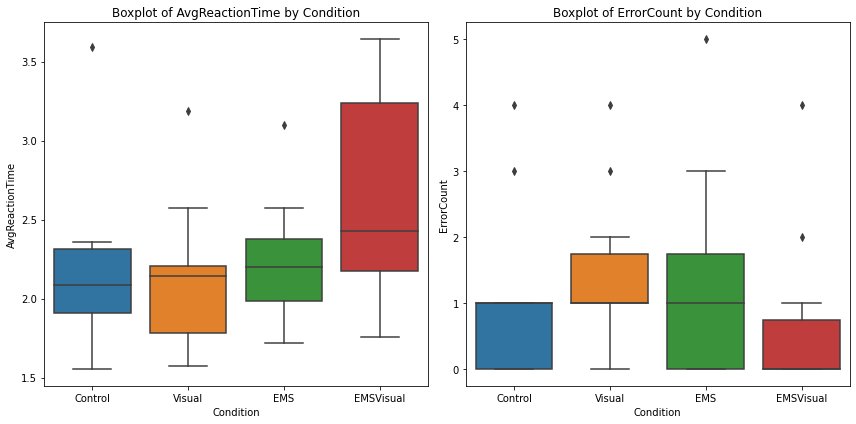

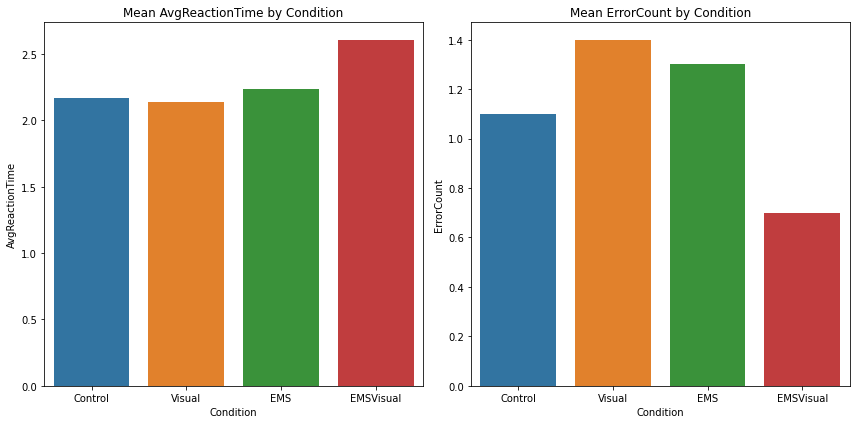

In [18]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('data.csv')

# Create boxplots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='Condition', y='AvgReactionTime', data=df)
plt.title('Boxplot of AvgReactionTime by Condition')

plt.subplot(1, 2, 2)
sns.boxplot(x='Condition', y='ErrorCount', data=df)
plt.title('Boxplot of ErrorCount by Condition')

plt.tight_layout()
plt.show()

# Create bar plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Condition', y='AvgReactionTime', data=df, ci=None)
plt.title('Mean AvgReactionTime by Condition')

plt.subplot(1, 2, 2)
sns.barplot(x='Condition', y='ErrorCount', data=df, ci=None)
plt.title('Mean ErrorCount by Condition')

plt.tight_layout()
plt.show()

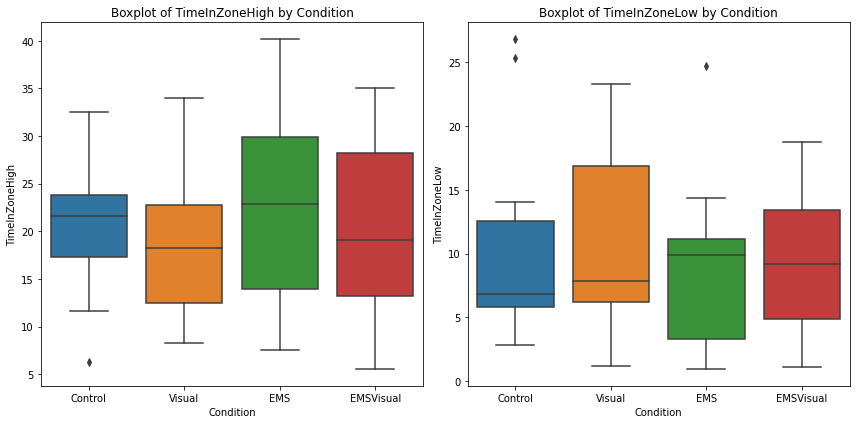

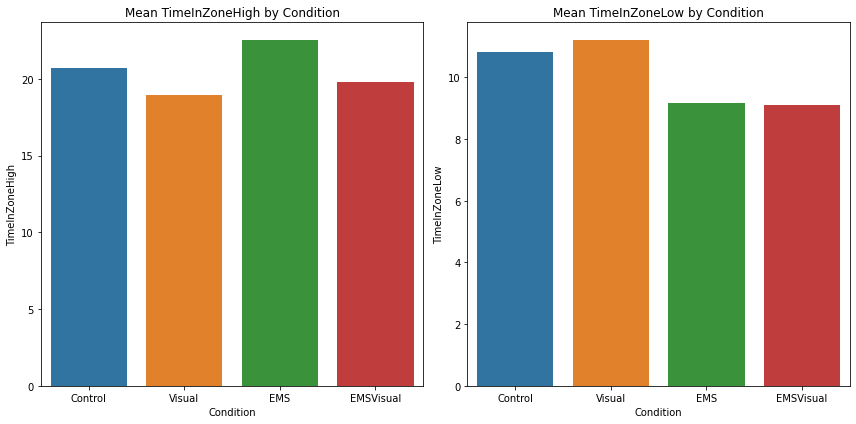

In [29]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('data.csv')

# Create boxplots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='Condition', y='TimeInZoneHigh', data=df)
plt.title('Boxplot of TimeInZoneHigh by Condition')

plt.subplot(1, 2, 2)
sns.boxplot(x='Condition', y='TimeInZoneLow', data=df)
plt.title('Boxplot of TimeInZoneLow by Condition')

plt.tight_layout()
plt.show()

# Create bar plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Condition', y='TimeInZoneHigh', data=df, ci=None)
plt.title('Mean TimeInZoneHigh by Condition')

plt.subplot(1, 2, 2)
sns.barplot(x='Condition', y='TimeInZoneLow', data=df, ci=None)
plt.title('Mean TimeInZoneLow by Condition')

plt.tight_layout()
plt.show()

In [38]:
# Import necessary libraries
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey HSD post-hoc test
posthoc = pairwise_tukeyhsd(df['ErrorCount'], df['Condition'], alpha=0.05)
print(posthoc)


   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj   lower  upper  reject
---------------------------------------------------------
  Control       EMS      0.2 0.9888 -1.4974 1.8974  False
  Control EMSVisual     -0.4 0.9201 -2.0974 1.2974  False
  Control    Visual      0.3 0.9639 -1.3974 1.9974  False
      EMS EMSVisual     -0.6 0.7771 -2.2974 1.0974  False
      EMS    Visual      0.1 0.9986 -1.5974 1.7974  False
EMSVisual    Visual      0.7 0.6854 -0.9974 2.3974  False
---------------------------------------------------------


In [39]:
# Import necessary libraries
import statsmodels.formula.api as smf

# Fit the model
model = smf.ols('ErrorCount ~ C(Condition)', data=df).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             ErrorCount   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                 -0.041
Method:                 Least Squares   F-statistic:                    0.4825
Date:                Thu, 27 Jul 2023   Prob (F-statistic):              0.697
Time:                        21:49:11   Log-Likelihood:                -68.374
No. Observations:                  40   AIC:                             144.7
Df Residuals:                      36   BIC:                             151.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             